#### &emsp; &emsp; &emsp; Matilde Tozzi &emsp; &emsp; &emsp; 256313 &emsp; &emsp; &emsp; Agosto 2021

# Drug Consumption (quantified) Data Set

Questo database contiene i record di 1885 intervistati, di cui sono note 12 features: 

- età;
- genere; 
- livello di istruzione;
- Paese di residenza;
- etnia;
- caratteristiche di personalità misurate tramite alcuni test psicologici 
    - NEO-FFI-R, che stima i cinque grandi tratti di personalità 
        - stabilità emotiva
        - estroversione
        - apertura mentale 
        - amicalità
        - coscienziosità        
    - BIS-11 (impulsività),
    - ImpSS (ricerca di sensazioni).

Tutti gli attributi di input erano categorici ma sono stati quantificati e possono essere trattati come numeri reali. Inoltre, i partecipanti sono stati interrogati riguardo il loro uso di 18 droghe legali e illegali:

- alcol,
- anfetamine,
- nitrito di amile,
- benzodiazepine,
- cannabis,
- cioccolato,
- cocaina,
- caffeina,
- crack,
- ecstasy,
- eroina,
- ketamina,
- LSD,
- metadone,
- funghi,
- nicotina,
- sostanze psicoattive,
- sostanze volatili,

e una droga fittizia, Semeron, introdotta per identificare chi mente. 

Per ogni droga si poteva selezionare una delle seguenti risposte: 

0. mai usata,
1. usata più di 10 anni fa,
2. usata nell'ultima decade,
3. usata nell'ultimo anno, 
4. usata nell'ultimo mese,
5. usata nell'ultima settimana, 
6. usata nell'ultimo giorno.

Per ulteriori informazioni: http://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29#

### Importazione pacchetti

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from FisherDA import MultipleFisherDiscriminantAnalysis as MDA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, mean_absolute_error
from sklearn.neural_network import MLPClassifier

### Importazione dataset

"Puliamo" i dati rimuovendo lo user ID univoco e restituendo i valori categorici ai dati (per una visualizzazione migliore).

In [2]:
# evita problemi con il tipo di dati
types = {i : 'float32' for i in range(0,13)}

# importazione dataset
drugs = pd.read_csv('./drug_consumption.data', header=None, dtype=types)
# togliamo lo user ID
drugs.drop(axis=1, columns=0, inplace=True)
drugs.rename(columns={i: (i-1) for i in range(1,drugs.shape[1]+1)}, inplace=True)

# creiamo un nuovo dataframe con valori categorici
drugs_names = drugs.copy()
drugs_names[0].replace({-0.95197: "18-24", -0.07854: "25-34", 0.49788: "35-44", 1.09449: "45-54", 1.82213: "55-64", 2.59171: "65+"}, inplace=True)
drugs_names[1].replace({0.48246: "Female", -0.48246:  "Male"}, inplace=True)
drugs_names[2].replace({-2.43591: "0 - Left school before 16 years", -1.73790: "1 - Left school at 16 years", -1.43719: "2 - Left school at 17 years", -1.22751: "3 - Left school at 18 years", -0.61113: "4 - Some college or university", -0.05921: "5 - Professional certificate/ diploma", 0.45468: "6 - University degree", 1.16365: "7 - Masters degree", 1.98437: "8 - Doctorate degree"}, inplace=True)
drugs_names[3].replace({-0.09765: "Australia", 0.24923: "Canada", -0.46841: "New Zealand", -0.28519: "Other", 0.21128: "Republic of Ireland", 0.96082: "UK", -0.57009: "USA"}, inplace=True)
drugs_names[4].replace({-0.50212: "Asian", -1.10702: "Black", 1.90725: "Mixed-Black/Asian", 0.12600: "Mixed-White/Asian", -0.22166: "Mixed-White/Black", 0.11440: "Other", -0.31685: "White"}, inplace=True)
drugs_names[5].replace({-3.46436: "12", -0.67825: "29", 1.02119: "46", -3.15735: "13", -0.58016: "30", 1.13281: "47", -2.75696: "14", -0.46725: "31", 1.23461: "48", -2.52197: "15", -0.34799: "32", 1.37297: "49", -2.42317: "16", -0.24649: "33", 1.49158: "50", -2.34360: "17", -0.14882: "34", 1.60383: "51", -2.21844: "18", -0.05188: "35", 1.72012: "52", -2.05048: "19", 0.04257: "36", 1.83990: "53", -1.86962: "20", 0.13606: "37", 1.98437: "54", -1.69163: "21", 0.22393: "38", 2.12700: "55", -1.55078: "22", 0.31287: "39", 2.28554: "56", -1.43907: "23", 0.41667: "40", 2.46262: "57", -1.32828: "24", 0.52135: "41", 2.61139: "58", -1.19430: "25", 0.62967: "42", 2.82196: "59", -1.05308: "26", 0.73545: "43", 3.27393: "60", -0.92104: "27", 0.82562: "44", -0.79151: "28", 0.91093: "45"}, inplace=True)
drugs_names[6].replace({-3.27393: "16", -1.23177: "31", 0.80523: "45", -3.00537: "18", -1.09207: "32", 0.96248: "46", -2.72827: "19", -0.94779: "33", 1.11406: "47", -2.53830: "20", -0.80615: "34", 1.28610: "48", -2.44904: "21", -0.69509: "35", 1.45421: "49", -2.32338: "22", -0.57545: "36", 1.58487: "50", -2.21069: "23", -0.43999: "37", 1.74091: "51", -2.11437: "24", -0.30033: "38", 1.93886: "52", -2.03972: "25", -0.15487: "39", 2.12700: "53", -1.92173: "26", 0.00332: "40", 2.32338: "54", -1.76250: "27", 0.16767: "41", 2.57309: "55", -1.63340: "28", 0.32197: "42", 2.85950: "56", -1.50796: "29", 0.47617: "43", 3.00537: "58", -1.37639: "30", 0.63779: "44", 3.27393: "59"}, inplace=True)
drugs_names[7].replace({-3.27393: "24", -1.11902: "38", 0.58331: "50", -2.85950: "26", -0.97631: "39", 0.72330: "51", -2.63199: "28", -0.84732: "40", 0.88309: "52", -2.39883: "29", -0.71727: "41", 1.06238: "53", -2.21069: "30", -0.58331: "42", 1.24033: "54", -2.09015: "31", -0.45174: "43", 1.43533: "55", -1.97495: "32", -0.31776: "44", 1.65653: "56", -1.82919: "33", -0.17779: "45", 1.88511: "57", -1.68062: "34", -0.01928: "46", 2.15324: "58", -1.55521: "35", 0.14143: "47", 2.44904: "59", -1.42424: "36", 0.29338: "48", 2.90161: "60", -1.27553: "37", 0.44585: "49"}, inplace=True)
drugs_names[8].replace({-3.46436: "12", -1.34289: "34", 0.76096: "48", -3.15735: "16", -1.21213: "35", 0.94156: "49", -3.00537: "18", -1.07533: "36", 1.11406: "50", -2.90161: "23", -0.91699: "37", 1.2861: "51", -2.78793: "24", -0.76096: "38", 1.45039: "52", -2.70172: "25", -0.60633: "39", 1.61108: "53", -2.53830: "26", -0.45321: "40", 1.81866: "54", -2.35413: "27", -0.30172: "41", 2.03972: "55", -2.21844: "28", -0.15487: "42", 2.23427: "56", -2.07848: "29", -0.01729: "43", 2.46262: "57", -1.92595: "30", 0.13136: "44", 2.75696: "58", -1.77200: "31", 0.28783: "45", 3.15735: "59", -1.62090: "32", 0.43852: "46", 3.46436: "60", -1.47955: "33", 0.59042: "47"}, inplace=True)
drugs_names[9].replace({-3.46436: "17", -1.25773: "32", 0.58489: "46", -3.15735: "19", -1.13788: "33", 0.7583: "47", -2.90161: "20", -1.01450: "34", 0.93949: "48", -2.72827: "21", -0.89891: "35", 1.13407: "49", -2.57309: "22", -0.78155: "36", 1.30612: "50", -2.42317: "23", -0.65253: "37", 1.46191: "51", -2.30408: "24", -0.52745: "38", 1.63088: "52", -2.18109: "25", -0.40581: "39", 1.81175: "53", -2.04506: "26", -0.27607: "40", 2.04506: "54", -1.92173: "27", -0.14277: "41", 2.33337: "55", -1.78169: "28", -0.00665: "42", 2.63199: "56", -1.64101: "29", 0.12331: "43", 3.00537: "57", -1.51840: "30", 0.25953: "44", 3.46436: "59", -1.38502: "31", 0.41594: "45" }, inplace=True)
labels_list = ["Age", "Gender", "Education", "Country", "Ethnicity", "Neuroticism", "Extraversion", "Openness to experience", "Agreeableness", "Conscientiousness", "Impulsiveness", "Sensation seeking", "Alcohol", "Amphetamines", "Amyl nitrite", "Benzodiazepines", "Caffeine", "Cannabis", "Chocolate", "Cocaine", "Crack", "Ecstasy", "Heroin", "Ketamine", "Legal highs", "LSD", "Methadone", "Mushrooms", "Nicotine", "Semeron", "VSA"]
labels_dict = {i : labels_list[i] for i in range(0,drugs_names.shape[1])}
drugs_names.rename(columns=labels_dict, inplace=True)
pd.set_option('display.max_columns', None)
print('Dataset originario:')
display(drugs)
print('Dataset con valori categorici:')
display(drugs_names)

Dataset originario:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,5,0,0,0,4,5,4,0,0,0,0,0,3,3,0,0,0,0,5
1881,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,5,0,0,0,5,3,4,0,0,2,0,0,3,5,4,4,5,0,0
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,4,6,5,5,6,6,6,4,0,4,0,2,0,2,0,2,6,0,0
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,5,0,0,0,6,6,5,0,0,3,0,0,3,3,0,3,4,0,0


Dataset con valori categorici:


,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,Impulsiveness,Sensation seeking,Alcohol,Amphetamines,Amyl nitrite,Benzodiazepines,Caffeine,Cannabis,Chocolate,Cocaine,Crack,Ecstasy,Heroin,Ketamine,Legal highs,LSD,Methadone,Mushrooms,Nicotine,Semeron,VSA
0,35-44,Female,5 - Professional certificate/ diploma,UK,Mixed-White/Asian,39,36,42,37,42,-0.21712,-1.18084,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0
1,25-34,Male,8 - Doctorate degree,UK,White,29,52,55,48,41,-0.71126,-0.21575,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0
2,35-44,Male,5 - Professional certificate/ diploma,UK,White,31,45,40,32,34,-1.37983,0.40148,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0
3,18-24,Female,7 - Masters degree,UK,White,34,34,46,47,46,-1.37983,-1.18084,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0
4,35-44,Female,8 - Doctorate degree,UK,White,43,28,43,41,50,-0.21712,-0.21575,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,18-24,Female,4 - Some college or university,USA,White,25,51,57,48,33,0.88113,1.92173,5,0,0,0,4,5,4,0,0,0,0,0,3,3,0,0,0,0,5
1881,18-24,Male,4 - Some college or university,USA,White,33,51,50,48,30,0.88113,0.76540,5,0,0,0,5,3,4,0,0,2,0,0,3,5,4,4,5,0,0
1882,25-34,Female,6 - University degree,USA,White,47,30,37,31,31,0.52975,-0.52593,4,6,5,5,6,6,6,4,0,4,0,2,0,2,0,2,6,0,0
1883,18-24,Female,4 - Some college or university,USA,White,45,26,48,32,22,1.29221,1.22470,5,0,0,0,6,6,5,0,0,3,0,0,3,3,0,3,4,0,0


## Analisi dataset

### Features

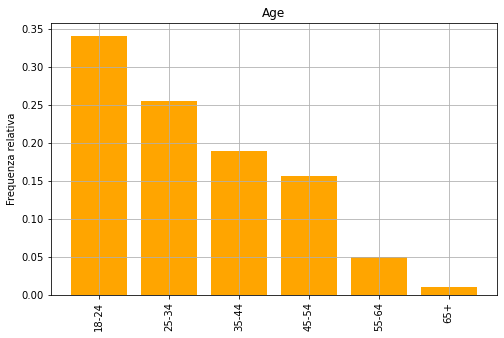

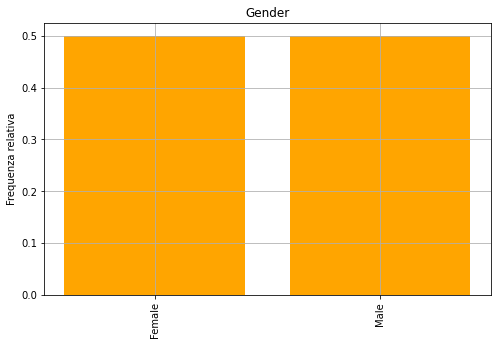

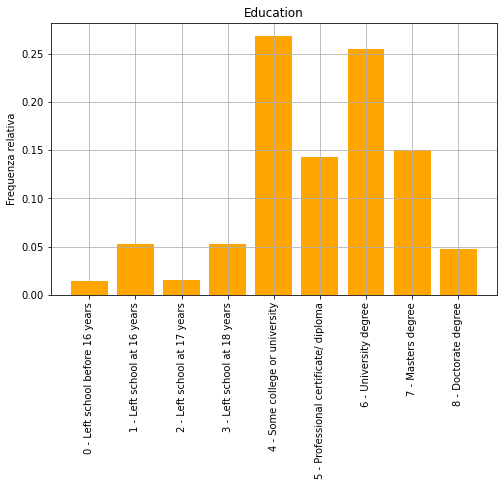

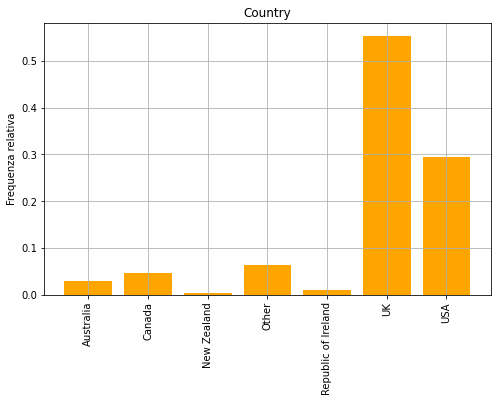

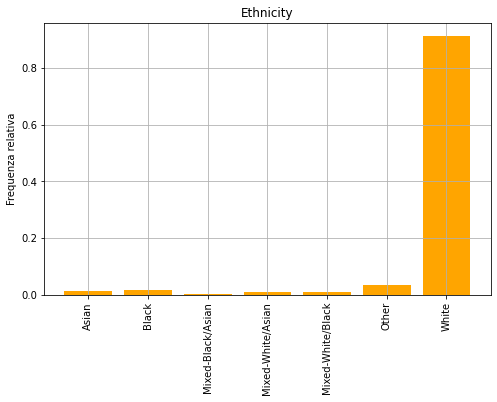

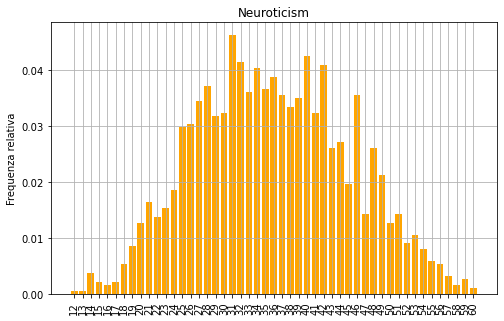

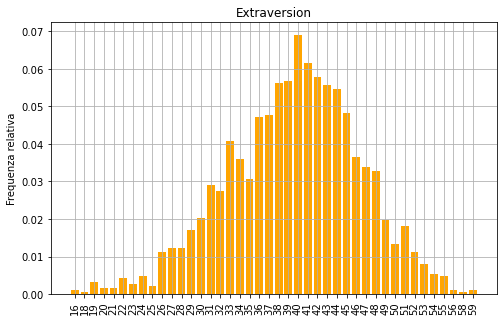

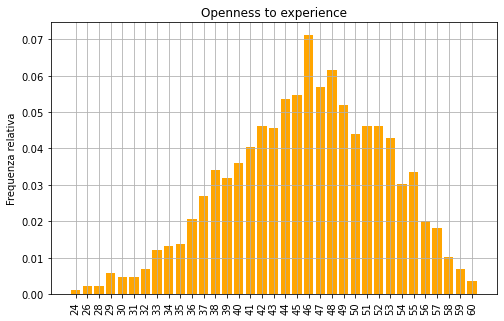

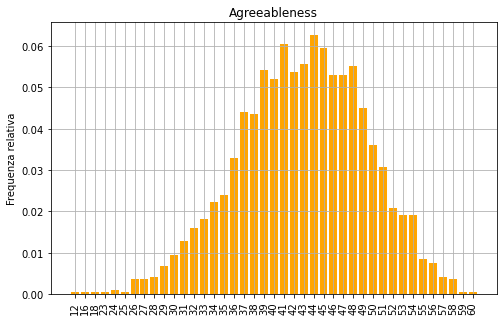

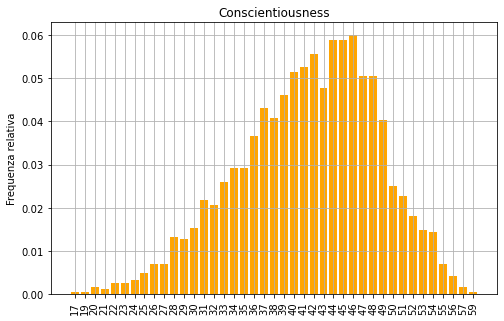

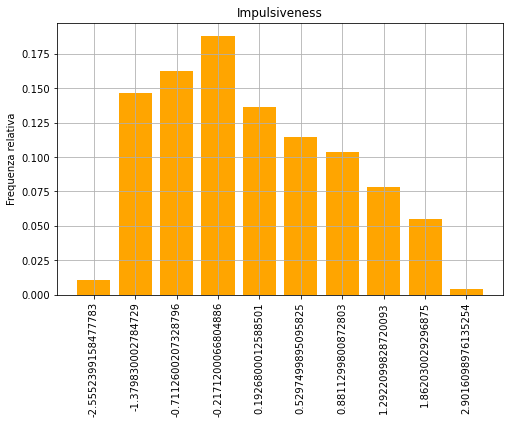

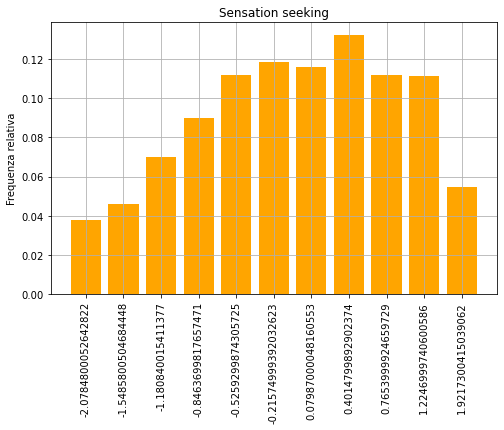

In [3]:
for feature in labels_list[:12]:
    counts = drugs_names[feature].value_counts(normalize=True).sort_index(axis=0)
    plt.figure(figsize=(8,5))
    plt.bar(np.arange(counts.size), counts, color='orange')
    plt.xticks(ticks=np.arange(counts.size), labels=counts.index, rotation=90)
    plt.title('{}'.format(feature))
    plt.grid()
    plt.ylabel('Frequenza relativa')
    plt.show()

Possiamo osservare che gli intervistati sono principalmente giovani bianchi anglosassoni, con un grado di istruzione medio-elevato. I due generi sono equamente rappresentati dal campione. È interessante osservare che i valori delle caratteristiche di personalità sembrano avere una distrubuzione normale.

### Target

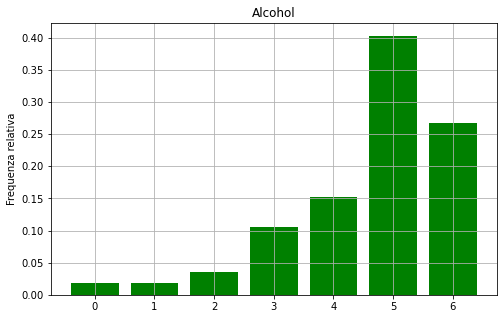

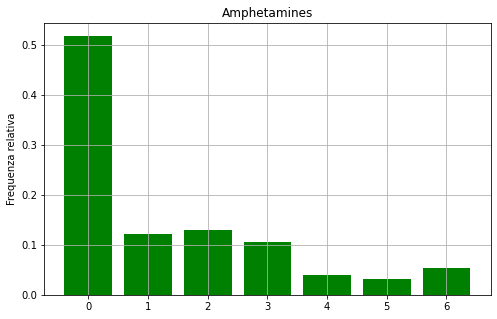

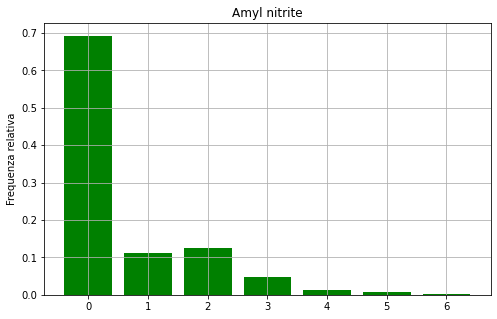

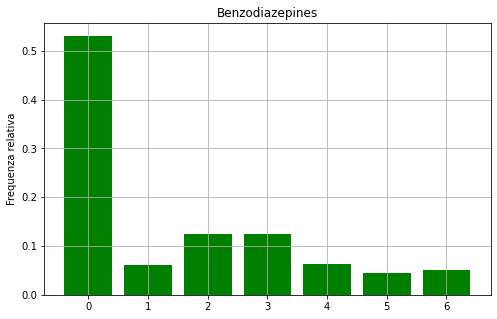

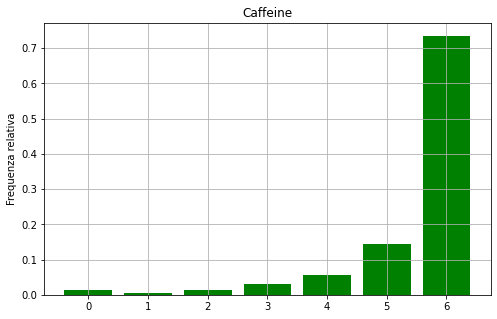

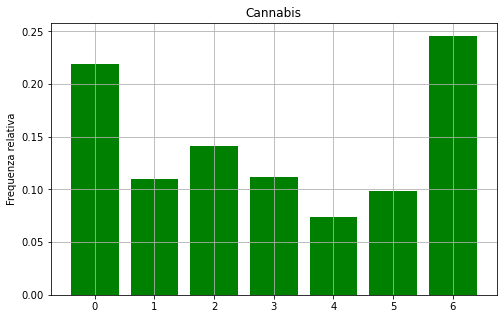

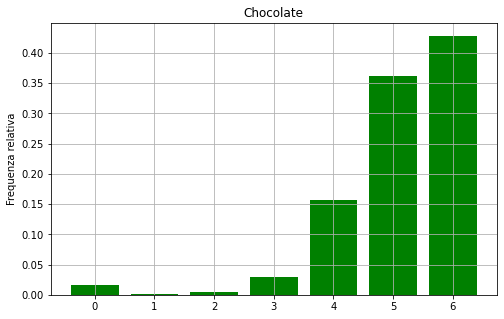

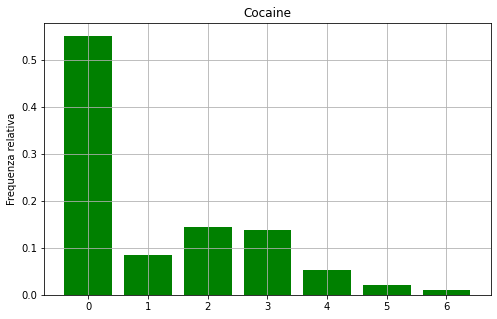

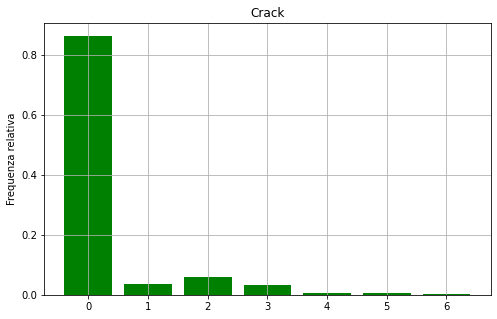

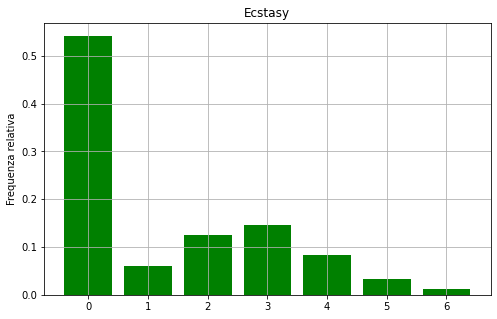

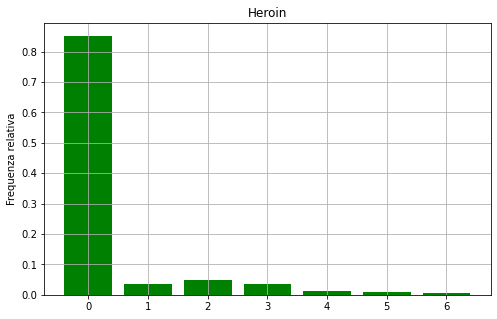

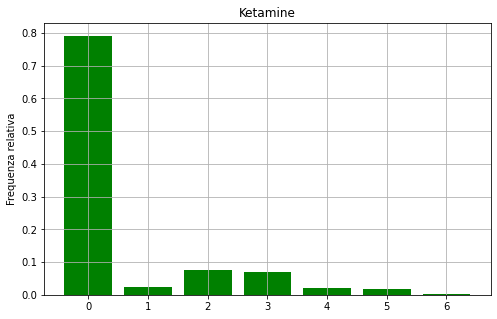

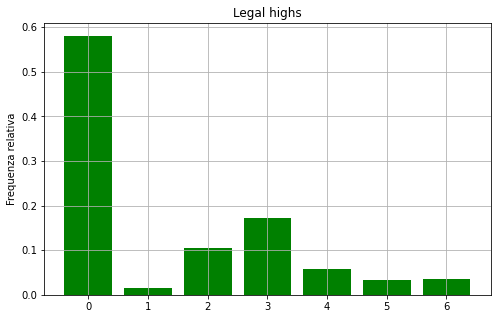

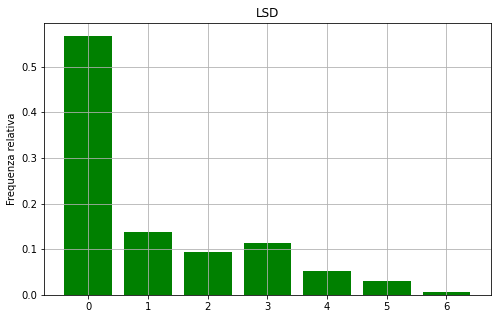

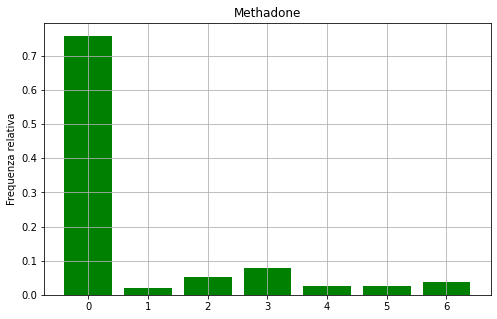

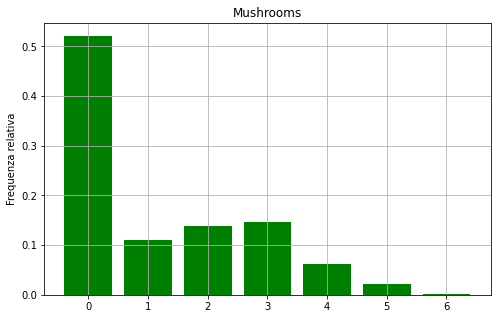

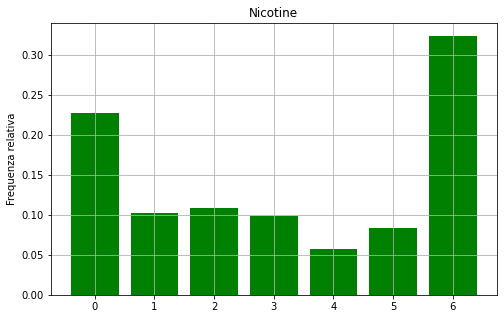

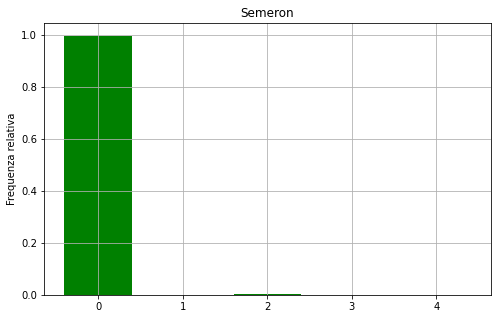

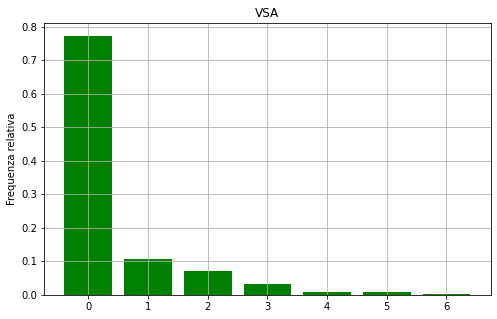

In [4]:
for drug in labels_list[12:]:
    counts = drugs_names[drug].value_counts(normalize=True).sort_index(axis=0)
    plt.figure(figsize=(8,5))
    plt.bar(np.arange(counts.size), counts, color='green')
    plt.xticks(ticks=np.arange(counts.size), labels=counts.index)
    plt.title('{}'.format(drug))
    plt.ylabel('Frequenza relativa')
    plt.grid()
    plt.show()

Osserviamo che molte droghe hanno dei livelli di utilizzo pesantemente sbilanciati, ma tra gli utilizzatori di alcune (Benzodiazepine, Cocaina, Crack, Ecstasy, Eroina, Ketamina, Metadone, Funghi) si intravede di nuovo una distribuzione normale. Il numero di utilizzatori della droga fittizia è trascurabile. Tra queste droghe scegliamo di concentrare le analisi su quelle con classi un po' meno sbilanciate, cioè Alcol, Anfetamine, Cannabis, Cioccolato, LSD, Funghi, Nicotina.

## Principal Component Analysis

La **Principal Component Analysis** (PCA) è un esempio di *unsupervised learning*, cioè non si utilizzano i dati di target, ma si cerca di estrarre informazioni utili unicamente dalle features a nostra disposizione. Inoltre, è un metodo di *riduzione di dimensionalità* che si concentra sul massimizzare la varianza nella rappresentazione a dimensione ridotta.

Si dimostra che le componenti principali sono gli autovettori corrispondenti agli autovalori di valore maggiore della matrice di covarianza dei dati. Questi autovalori rappresentano inoltre la varianza spiegata dalla singola componente principale. Per effettuare quindi la riduzione a una dimensione prestabilita $n$, si considera la matrice formata dalle $n$ componenti principali, che secondo il teorema spettrale sono ortonormali (poiché la matrice di covarianza è simmetrica) e formano una base in $\mathbb{R}^n$ in cui proiettare i dati. Viceversa, se si vuole ottenere una rappresentazione che spieghi almeno una certa quantità di varianza $v$, si prenderanno come base gli autovettori corrispondenti agli autovalori la cui somma superi $v$, partendo dagli autovalori di valore maggiore.

La PCA è inoltre un esempio di *auto encoder lineare*. Un auto encoder codifica un dato in un codice e lo decodifica in un dato simile all'originale. Con la PCA la mappa è la matrice di proiezione che individua quindi una trasformazione lineare. L'obiettivo in questo caso è minimizzare l'errore quadratico medio tra il dato originale e la sua ricostruzione e si trova che questo problema è equivalente a quello descritto in precedenza.

Numero PC: 8
% Varianza Tot. Spiegata: 0.9136207103729248


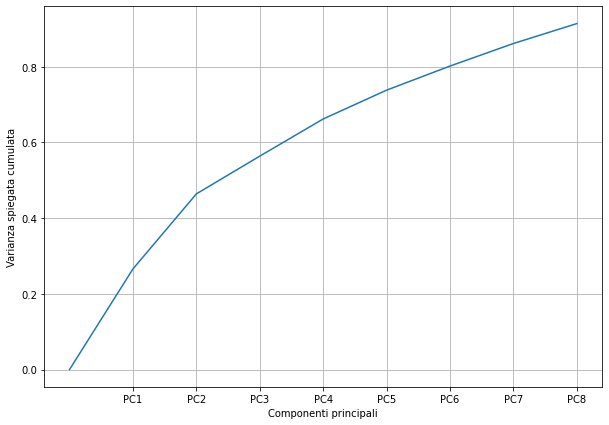

In [5]:
# prendiamo solo i dati su cui effettuare la PCA
PCA_data = drugs.loc[:,[i for i in range(0,12)]].values

# inizializziamo la PCA con varianza spiegata pari al 90%
pca = PCA(0.9)
pca.fit(PCA_data)
print('Numero PC: {}'.format(pca.n_components_))
print('% Varianza Tot. Spiegata: {}'.format(pca.explained_variance_ratio_.sum()))

# visualizzazione varianza spiegata cumulata
plt.figure(figsize=(10,7))
plt.plot(np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0))
plt.xticks(ticks=np.arange(1, pca.n_components_ + 1), 
           labels=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
plt.xlabel('Componenti principali')
plt.ylabel('Varianza spiegata cumulata')
plt.grid()
plt.show()

Per spiegare una varianza di almeno il 90%, abbiamo bisogno in questo caso di 8 componenti principali.

In questo caso i dati non sono stati standardizzati in quanto la varianza delle features era abbastanza bilanciata e il risultato non cambiava sensibilmente. È stato usato l'encoding originario del dataset.

### Interpretazione delle componenti principali 

Vediamo il contributo delle features originali per le componenti principali, per capire cosa descrive meglio il nostro dataset.

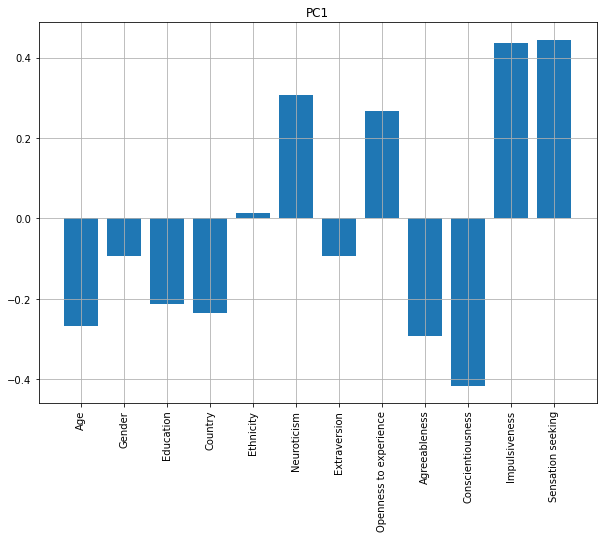

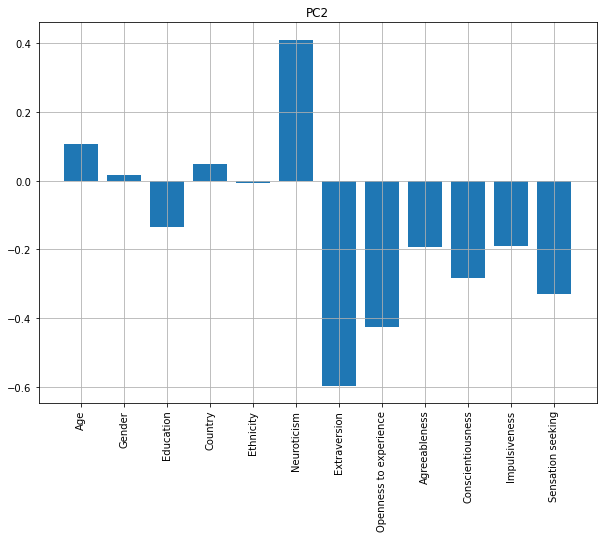

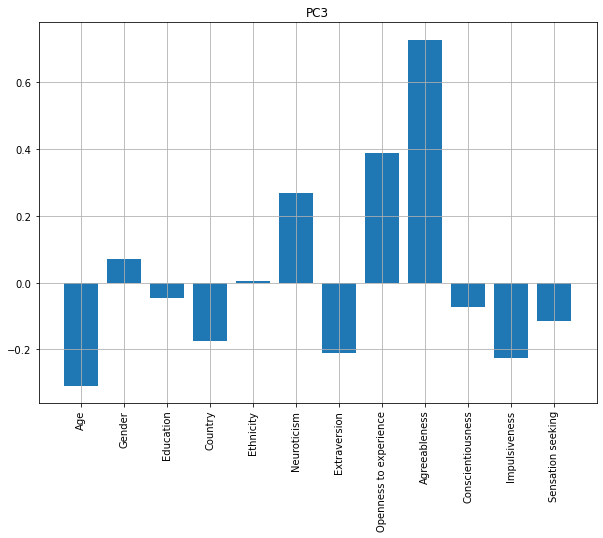

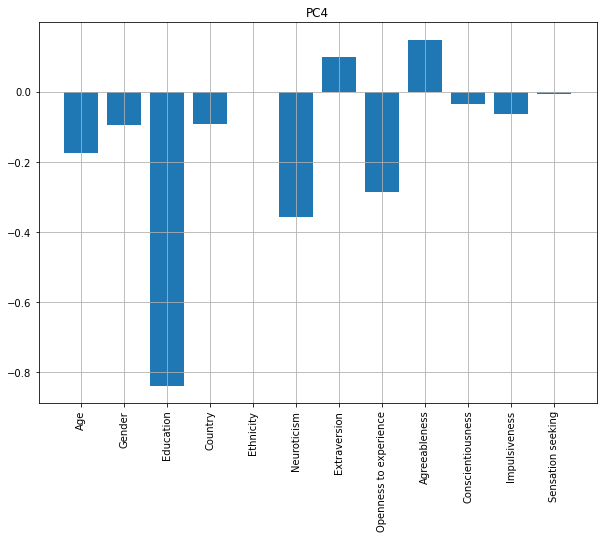

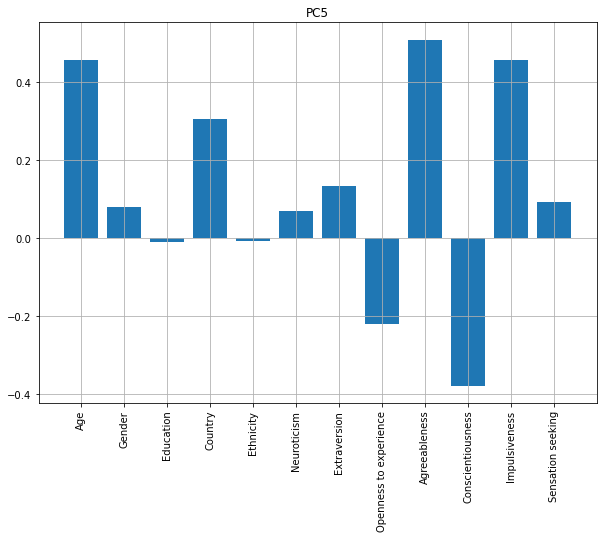

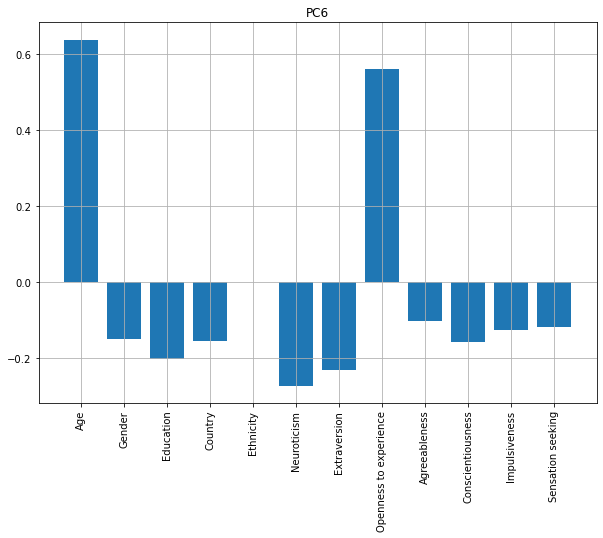

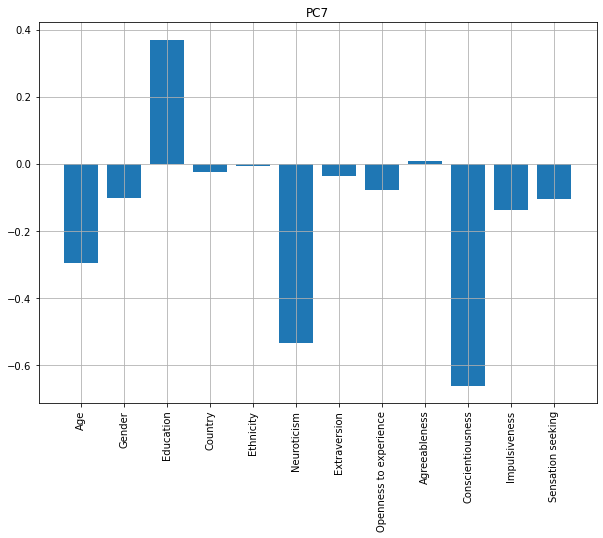

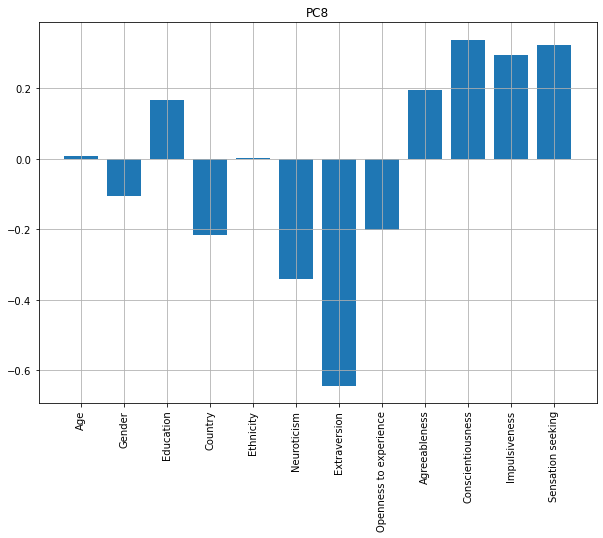

In [6]:
for i in range(0, pca.n_components_):
    plt.figure(figsize=(10,7))
    plt.bar(np.arange(pca.n_features_), pca.components_[i, :])
    plt.xticks(ticks=np.arange(pca.n_features_), labels=labels_list[0:pca.n_features_], rotation=90)
    plt.title('PC{}'.format(i+1))
    plt.grid()
    plt.show()

A ogni componente principale possiamo attribuire una descrizione:

1. coscienziosità, impulsività e ricerca di sensazioni;
2. stabilità emotiva, estroversione e apertura mentale;
3. amicalità;
4. livello di istruzione;
5. età, amicalità e impulsività;
6. età e apertura mentale;
7. stabilità emotiva e coscienziosità;
8. estroversione.

Sono state prese in esame le features che contribuiscono più del 40% in positivo o in negativo.

È interessante osservare come le caratteristiche di personalità giochino un ruolo preponderante nella descrizione del dataset.

## Multiple Discriminant Analysis 

La **Multiple Discriminant Analysis** (MDA) è un metodo di *riduzione di dimensionalità* per dataset di cui si conosce già una classificazione. È quindi al contrario della PCA un metodo di *supervised learning* che proietta i dati in uno spazio minore (al più in dimensione $\text{numero classi}-1$) in modo da massimizzare la distanza tra le classi tramite l'uso dei loro centroidi, tenendo in considerazione la varianza dei dati in quella direzione. È la versione multiclasse della *Fisher Discriminant Analysis* (solo binaria).

Per questa parte, consideriamo la differenza nella riduzione di dimensionalità tra la MDA e la PCA. Per migliorare la visualizzazione, consideriamo la proiezione su *tre* componenti, anche se l'accuratezza della rappresentazione è certamente bassa (appena il 56% di varianza spiegata con la PCA). Come target, le scelte possono essere molteplici. Scegliamo per questa analisi i sette diversi livelli di utilizzo di alcune droghe (Alcol, Anfetamine, Cannabis, Cioccolato, LSD, Funghi, Nicotina). Abbiamo scelto questo ridotto elenco di droghe per snellire le analisi e perché sono alcuni degli insiemi più bilanciati.

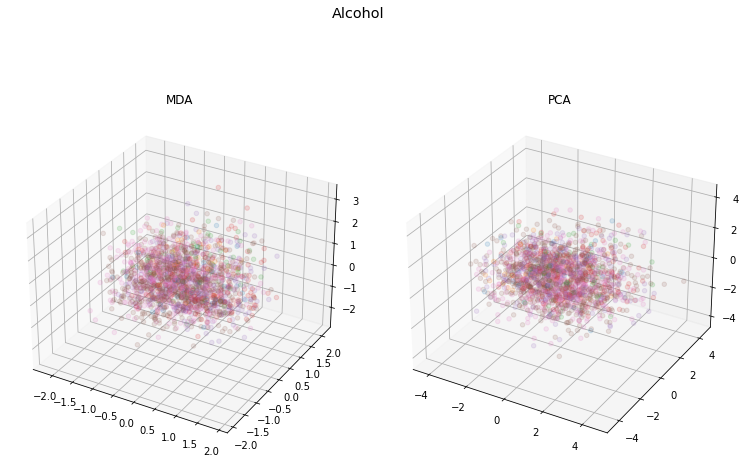

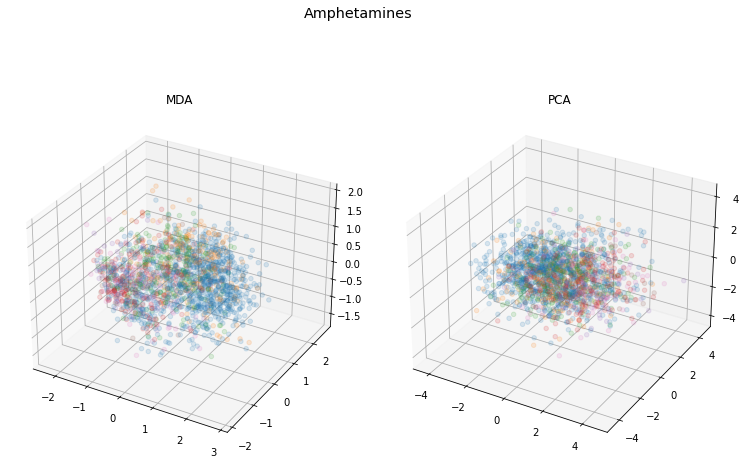

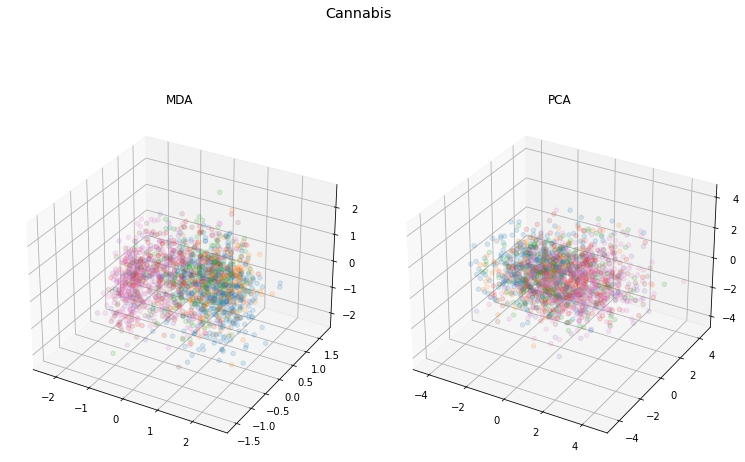

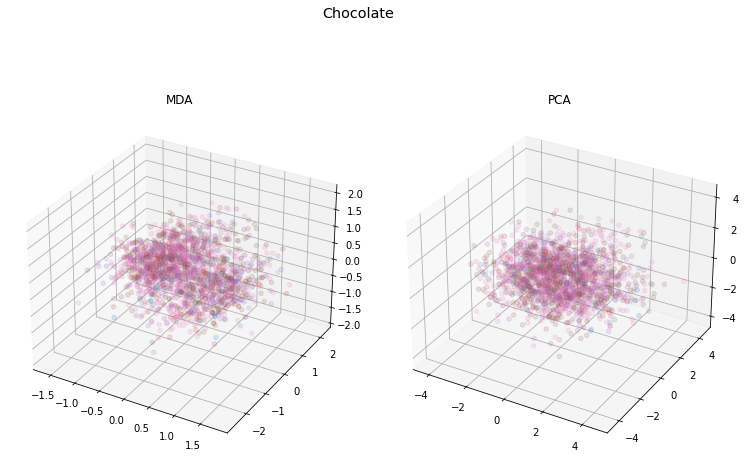

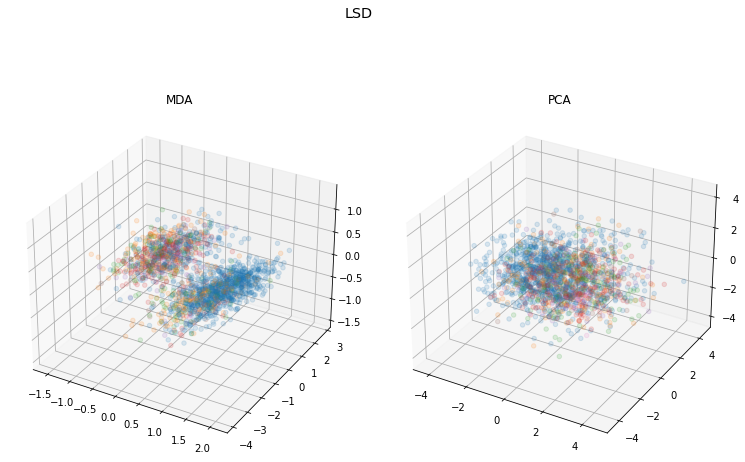

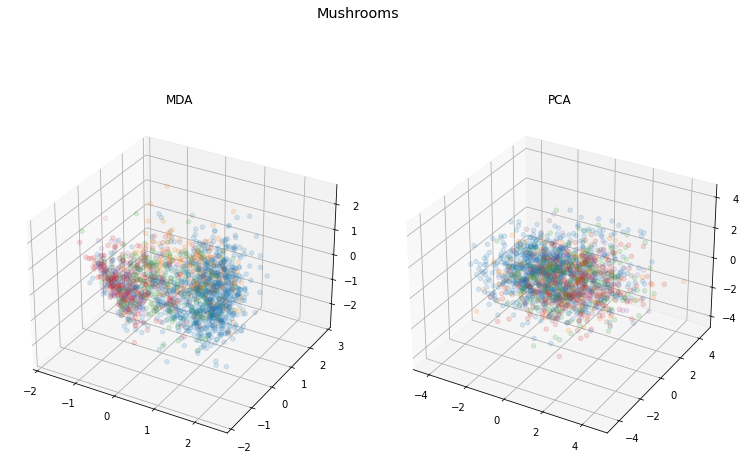

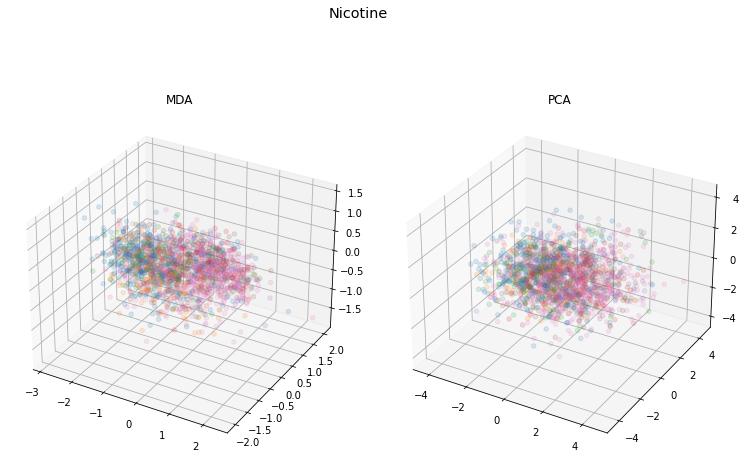

In [7]:
# lista delle droghe considerate
drugs_list = ["Alcohol", "Amphetamines", "Cannabis", "Chocolate", "LSD", "Mushrooms", "Nicotine"]

for drug in drugs_list: 
    # inizializzazione MDA e PCA con tre componenti
    mda_3dim = MDA(n_dimensions=3)
    pca_3dim = PCA(n_components=3)

    # prendiamo come target la droga che ci interessa (anche dal dataset con i nomi, i valori sono uguali)
    mda_target = drugs_names[drug].values

    # facciamo il 'fit' degli oggetti inizializzati
    mda_3dim.fit(PCA_data, mda_target)
    pca_3dim.fit(PCA_data)

    # proiettiamo in tre dimensioni
    mda_Z = mda_3dim.transform(PCA_data)
    pca_Z = pca_3dim.transform(PCA_data)

    class_colors = [plt.cm.tab10.colors[c] for c in mda_target]

    # plottiamo MDA e PCA
    fig = plt.figure(figsize=(13, 8))
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    ax0 = fig.add_subplot(1, 2, 1, projection='3d')
    ax0.scatter(mda_Z[:, 0], mda_Z[:, 1], mda_Z[:, 2], c=class_colors, alpha=0.15)
    ax0.set_title('MDA')

    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    ax1.scatter(pca_Z[:, 0], pca_Z[:, 1], pca_Z[:, 2], c=class_colors, alpha=0.15)
    ax1.set_title('PCA')
    
    fig.suptitle('{}'.format(drug), size='x-large')
    
    plt.show()

Poiché la Multiple Discriminant Analysis lavora massimizzando la separazione tra le classi, esse sono un po' più visibili nel grafico, soprattutto per LSD, funghi e nicotina, anche se tre dimensioni rimangono insufficienti per una divisione accurata.

## Support Vector Machines
Le **Support Vector Machines** (SVM) sono uno strumento di *classificazione binaria* (eventualmente estendibile al caso multiclasse, come vedremo in seguito). L'idea di base è suddividere lo spazio delle features in due parti tramite un iperpiano, massimizzando il margine di separazione. Si possono creare dei margini "morbidi" per ammettere alcuni errori di classificazione tramite un fattore di regolarizzazione $C$, altrimenti si rischia di non trovare nessun iperpiano di separazione se i dati non sono perfettamente linearmente separabili. <br>
Se i due insiemi da classificare sono altamente non lineari, si possono ancora utilizzare le SVM spostando il problema in uno spazio a dimensione maggiore, dove la separazione diventa almeno quasi lineare. Solitamente non si utilizza una mappa diretta per il passaggio a uno spazio di dimensione superiore, ma il cosiddetto *kernel trick*: il kernel $k: \mathcal{X}\times  \mathcal{X} \rightarrow \mathbb{R}$ è una funzione per cui esiste un'unica mappa $\phi :  \mathcal{X} \rightarrow  \mathcal{H}\subseteq\mathbb{R}^m$ tale per cui $\langle\phi(\boldsymbol{x}_i),\phi(\boldsymbol{x}_i)\rangle_{\mathcal{H}} = k(\boldsymbol{x}_i,\boldsymbol{x}_j)$, dove $\mathcal{X}\subseteq\mathbb{R}^n$, $m>n$ e $\mathcal{H}$ *spazio di Hilbert*. I vantaggi di questo tipo di operazione sono principalmente due:
- i calcoli sono svolti in $\mathbb{R}^n$, cioè nella dimensione dei vettori del problema, e questo ci consente di aumentare la dimensione dello spazio in cui si lavora senza problemi;
- non bisogna conoscere esplicitamente $\phi$.

Solitamente per le kernel SVM si risolve il problema di ottimizzazione duale, che ha proprio la formulazione ideale per l'applicazione del kernel trick.

I kernel utilizzati nella nostra analisi sono:
- *Kernel Lineare*: è il kernel corrispondente al caso in cui $\phi$ sia l'identità (cioè è il kernel delle SVM lineari). $\langle\phi(\boldsymbol{x}_i),\phi(\boldsymbol{x}_i)\rangle_{\mathcal{H}} = \langle \boldsymbol{x}_i, \boldsymbol{x}_j\rangle_{\mathcal{X}}$ <br>
dove di solito il prodotto scalare in $\mathcal{X}$ è lo stesso di $\mathbb{R}^n$ che induce la norma euclidea $||\cdot||_2$, cioè $\langle \boldsymbol{x}_i, \boldsymbol{x}_j\rangle_{\mathcal{X}} = \boldsymbol{x}_i^\top \boldsymbol{x}_j$;

- *Kernel Polinomiale*: $\langle\phi(\boldsymbol{x}_i),\phi(\boldsymbol{x}_i)\rangle_{\mathcal{H}} = \left(\gamma \, \langle \boldsymbol{x}_i, \boldsymbol{x}_j\rangle_{\mathcal{X}} + c_0 \right)^d$;

- *Radial Basis Function (RBF) Kernel*: $\langle\phi(\boldsymbol{x}_i),\phi(\boldsymbol{x}_i)\rangle_{\mathcal{H}} = e^{-\gamma \, \langle \boldsymbol{x}_i, \boldsymbol{x}_j\rangle_{\mathcal{X}}^2}$;

- *Kernel Sigmoidale*: $\langle\phi(\boldsymbol{x}_i),\phi(\boldsymbol{x}_i)\rangle_{\mathcal{H}} = \tanh\left(\gamma \, \langle \boldsymbol{x}_i, \boldsymbol{x}_j\rangle_{\mathcal{X}} + c_0 \right)$.

I parametri $\gamma$ e $c_0$ influenzano l'addestramento delle SVM. In particolare, all'aumentare di $\gamma$ aumenta l'influenza dei singoli elementi del training set sull'addestramento. $c_0$ svolge un ruolo simile ma meno preponderante.

Per estendere l'uso delle SVM al caso multiclasse (con $t>2$ classi), si esegue di solito il metodo *One-VS-One*, cioè si addestrano $\begin{pmatrix}t \\ 2\end{pmatrix}$ SVM per ogni coppia di classi e si usa come predizione per un certo dato quella ottenuta dal maggior numero delle SVM.
<br>
<br>

Nella nostra analisi, procediamo con una **grid search** per la determinazione dei migliori iperparametri e del miglior kernel per le SVM. Testiamo i kernel *lineare*, *polinomiale*, *RBF* e *sigmoidale*, con $C \in \{2^i|i=-2,...,2\}$, $\gamma \in \{\frac{1}{i\cdot n}| i= 0.5,1,1.5\}$ dove $n$ è il numero di features del dataset.

Utilizziamo un training, validation e test set, che corrispondono rispettivamente al 30%, 20% e 50% del dataset originale.

Per comodità di visualizzazione mostriamo solo i primi 5 migliori risultati per ogni ricerca, che effettuiamo sulle stesse 7 droghe analizzate in precedenza.

In [8]:
SVM_data = drugs.loc[:,[i for i in range(0,12)]].values

# dividiamo i dati in training, validation e test set
test_p = 0.5
val_p = 0.4
random_seed = 112358
idx = np.arange(SVM_data.shape[0])
ind_train, ind_test = train_test_split(idx, test_size=test_p, random_state=random_seed, shuffle=True)
ind_train, ind_val = train_test_split(ind_train, test_size=val_p, random_state=random_seed, shuffle=True)

# definiamo le liste di valori per la grid search
C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * 12) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

# le inseriamo in un dizionario
hparameters = {'kernel':ker_list, 'C':C_list, 'gamma':gamma_list}

# specifichiamo il tipo di SVM su cui effettuare la ricerca
svm = SVC(class_weight='balanced')

# salviamo i parametri trovati nei vari cicli in un dizionario
best_parameters = {}

for drug in drugs_list: 
    # inizializziamo la gridsearch 
    svm_gs = GridSearchCV(estimator=svm, param_grid=hparameters, scoring='f1_weighted', return_train_score=True, cv=zip([ind_train], [ind_val]))
    
    # selezioniamo la droga target
    SVM_targets = drugs_names[drug].values
    
    # effettuiamo il fit dei dati
    svm_gs.fit(SVM_data, SVM_targets)
    
    # salviamo i migliori parametri
    best_parameters[drug] = svm_gs.best_params_

    # mostriamo i risultati della Gridsearch con un dataframe
    df_results = pd.DataFrame(svm_gs.cv_results_)
    df_results.drop(columns=['params', 'mean_fit_time', 'mean_score_time', 'std_fit_time', 'std_score_time', 'std_test_score', 'std_train_score', 'split0_test_score', 'split0_train_score'], inplace=True)
    print('Risultati per: {}'.format(drug))
    display(df_results.sort_values(['rank_test_score'], ascending=True).head())

Risultati per: Alcohol


,param_C,param_gamma,param_kernel,mean_test_score,rank_test_score,mean_train_score
48,4,0.166667,rbf,0.300813,1,0.846396
57,4,0.0555556,poly,0.289926,2,0.518459
36,2,0.166667,rbf,0.286606,3,0.707334
52,4,0.0833333,rbf,0.285783,4,0.614160
1,0.25,0.166667,poly,0.282564,5,0.601031


Risultati per: Amphetamines


,param_C,param_gamma,param_kernel,mean_test_score,rank_test_score,mean_train_score
53,4,0.0833333,poly,0.451659,1,0.735116
13,0.5,0.166667,poly,0.451659,1,0.735116
25,1,0.166667,poly,0.449124,3,0.788439
49,4,0.166667,poly,0.443980,4,0.873904
37,2,0.166667,poly,0.439480,5,0.829203


Risultati per: Cannabis


,param_C,param_gamma,param_kernel,mean_test_score,rank_test_score,mean_train_score
56,4,0.0555556,rbf,0.325543,1,0.607825
40,2,0.0833333,rbf,0.320875,2,0.624759
24,1,0.166667,rbf,0.320258,3,0.706490
52,4,0.0833333,rbf,0.316604,4,0.705664
44,2,0.0555556,rbf,0.311317,5,0.538273


Risultati per: Chocolate


,param_C,param_gamma,param_kernel,mean_test_score,rank_test_score,mean_train_score
37,2,0.166667,poly,0.339995,1,0.789624
25,1,0.166667,poly,0.325597,2,0.726592
24,1,0.166667,rbf,0.319940,3,0.642324
48,4,0.166667,rbf,0.319449,4,0.860240
36,2,0.166667,rbf,0.317767,5,0.743798


Risultati per: LSD


,param_C,param_gamma,param_kernel,mean_test_score,rank_test_score,mean_train_score
36,2,0.166667,rbf,0.532753,1,0.843293
52,4,0.0833333,rbf,0.528154,2,0.780813
48,4,0.166667,rbf,0.527861,3,0.894940
29,1,0.0833333,poly,0.517856,4,0.673957
53,4,0.0833333,poly,0.512587,5,0.784822


Risultati per: Mushrooms


,param_C,param_gamma,param_kernel,mean_test_score,rank_test_score,mean_train_score
1,0.25,0.166667,poly,0.477414,1,0.719839
41,2,0.0833333,poly,0.477414,1,0.719839
52,4,0.0833333,rbf,0.476780,3,0.769873
13,0.5,0.166667,poly,0.475833,4,0.771110
53,4,0.0833333,poly,0.475833,4,0.771110


Risultati per: Nicotine


,param_C,param_gamma,param_kernel,mean_test_score,rank_test_score,mean_train_score
36,2,0.166667,rbf,0.294791,1,0.754849
48,4,0.166667,rbf,0.286689,2,0.877945
24,1,0.166667,rbf,0.275782,3,0.634476
28,1,0.0833333,rbf,0.269935,4,0.451757
44,2,0.0555556,rbf,0.269746,5,0.436138


Osserviamo che non c'è un kernel migliore in generale e ogni droga utilizza degli iperparametri diversi. Tuttavia, osserviamo che anche in dimensioni superiori le classi non sono linearmente separabili (non viene mai utilizzato il kernel lineare).

#### Performance delle migliori SVM

Ora valutiamo le performance della migliore SVM trovata per ogni droga, calcolando *accuratezza*, *precision*, *recall*, *F1-score* e *errore medio assoluto* su training, validation e test set.

La **accuratezza** è il numero di previsioni corrette sul totale delle previsioni: $\mathrm{acc}(\mathcal{P}) = \frac{\text{predizioni corrette su }\mathcal{P}}{|\mathcal{P}|}$

La **precision** è la precisione del modello nel classificare gli elementi di una certa classe: $\mathrm{prec}(C_i;\mathcal{P}) = \frac{\text{veri }C_i}{\text{elem. di $\mathcal{P}$ pred. come $C_i$}}$. Nel nostro caso, è visualizzata la media per tutte le classi.

La **recall** è il tasso di campioni di una certa classe riconosciuti correttamente: $\mathrm{rec}(C_i;\mathcal{P}) = \frac{\text{veri }C_i}{C_i \text{ in }\mathcal{P}}$. Nel nostro caso, è visualizzata la media per tutte le classi.

Il **F-beta score** è una misura che aggrega la precision e la recall ed è definita come $F_\beta(C_i;\mathcal{P}) = (1 + \beta^2) \ \frac{\mathrm{prec}(C_i;\mathcal{P}) \cdot \mathrm{rec}(C_i;\mathcal{P})}{\beta^2 \ \mathrm{prec}(C_i;\mathcal{P}) + \mathrm{rec}(C_i;\mathcal{P})}$. I valori di $F_\beta$ sono sempre in $[0, 1]$ e descrivono "bontà" e "robustezza" delle predizioni del modello ($1$ massimo, $0$ minimo). Il *F1-score* utilizzato è naturalmente quando $\beta=1$.

Abbiamo deciso di aggiungere alla analisi anche l'**errore medio assoluto**, cioè di quante classi in media il modello si discosta dalla classe giusta nella predizione.

In [9]:
for drug in drugs_list:
    print('Dati per: {}'.format(drug))
    print(best_parameters[drug])
    
    # addestramento SVM
    SVM = SVC(C=best_parameters[drug]['C'], kernel=best_parameters[drug]['kernel'], gamma=best_parameters[drug]['gamma'], random_state=random_seed)
    SVM.fit(SVM_data[ind_train,:], SVM_targets[ind_train])
    
    # predizioni nei tre set
    y_pred_train = SVM.predict(SVM_data[ind_train, :])
    y_true_train = SVM_targets[ind_train]
    y_pred_val = SVM.predict(SVM_data[ind_val, :])
    y_true_val = SVM_targets[ind_val]
    y_pred = SVM.predict(SVM_data[ind_test, :])
    y_true = SVM_targets[ind_test]

    # accuracy, precision, recall, F1 score ed errore medio assoluto per training set
    acc_train = SVM.score(SVM_data[ind_train, :], y_true_train)
    prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
    rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
    f1_train = f1_score(y_true_train, y_pred_train, average='weighted')
    mae_train = mean_absolute_error(y_true_train, y_pred_train)

    # accuracy, precision, recall, F1 score ed errore medio assoluto per validation set
    acc_val = SVM.score(SVM_data[ind_val, :], y_true_val)
    prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
    rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
    f1_val = f1_score(y_true_val, y_pred_val, average='weighted')
    mae_val = mean_absolute_error(y_true_val, y_pred_val)

    # accuracy, precision, recall, F1 score ed errore medio assoluto per test set
    acc = SVM.score(SVM_data[ind_test, :], y_true)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)

    df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 'Precision': [prec_train, prec_val, prec], 'Recall': [rec_train, rec_val, rec], 'F1': [f1_train, f1_val, f1], 'MAE': [mae_train, mae_val, mae]}, index=['training', 'validation', 'test'])
    display(df_perf)

Dati per: Alcohol
{'C': 4, 'gamma': 0.16666666666666666, 'kernel': 'rbf'}


,Accuracy,Precision,Recall,F1,MAE
training,0.909735,0.914172,0.909735,0.908894,0.290265
validation,0.302387,0.283498,0.302387,0.282601,2.204244
test,0.330859,0.295043,0.330859,0.307122,2.150583


Dati per: Amphetamines
{'C': 0.5, 'gamma': 0.16666666666666666, 'kernel': 'poly'}


,Accuracy,Precision,Recall,F1,MAE
training,0.608850,0.736097,0.608850,0.573525,1.295575
validation,0.307692,0.253941,0.307692,0.237742,2.374005
test,0.359491,0.290805,0.359491,0.292674,2.236479


Dati per: Cannabis
{'C': 4, 'gamma': 0.05555555555555555, 'kernel': 'rbf'}


,Accuracy,Precision,Recall,F1,MAE
training,0.520354,0.682973,0.520354,0.445110,1.559292
validation,0.360743,0.255692,0.360743,0.254979,2.119363
test,0.396607,0.352843,0.396607,0.301442,2.100742


Dati per: Chocolate
{'C': 2, 'gamma': 0.16666666666666666, 'kernel': 'poly'}


,Accuracy,Precision,Recall,F1,MAE
training,0.815929,0.848713,0.815929,0.814247,0.624779
validation,0.286472,0.248795,0.286472,0.255167,2.294430
test,0.313892,0.280790,0.313892,0.289805,2.239661


Dati per: LSD
{'C': 2, 'gamma': 0.16666666666666666, 'kernel': 'rbf'}


,Accuracy,Precision,Recall,F1,MAE
training,0.750442,0.794577,0.750442,0.739023,0.789381
validation,0.347480,0.293272,0.347480,0.285561,2.169761
test,0.383881,0.333045,0.383881,0.325078,2.113468


Dati per: Mushrooms
{'C': 0.25, 'gamma': 0.16666666666666666, 'kernel': 'poly'}


,Accuracy,Precision,Recall,F1,MAE
training,0.530973,0.717165,0.530973,0.468118,1.610619
validation,0.320955,0.220673,0.320955,0.227322,2.432361
test,0.371156,0.291389,0.371156,0.279750,2.303287


Dati per: Nicotine
{'C': 2, 'gamma': 0.16666666666666666, 'kernel': 'rbf'}


,Accuracy,Precision,Recall,F1,MAE
training,0.750442,0.794577,0.750442,0.739023,0.789381
validation,0.347480,0.293272,0.347480,0.285561,2.169761
test,0.383881,0.333045,0.383881,0.325078,2.113468


Osserviamo che l'errore medio assoluto è di circa due classi, quindi ci chiediamo se la SVM lavorerebbe meglio in una classificazione ternaria.

### SVM a tre classi

Effettuiamo quindi la stessa analisi svolta in precedenza, ma rendendo il problema ternario: consideriamo *non utilizzatori* i soggetti di livello 0, 1 e 2, *utilizzatori saltuari* quelli di livello 3 e 4 e infine *utilizzatori frequenti* quelli di livello 5 e 6.

In [10]:
for drug in drugs_list: 
    # inizializziamo la gridsearch 
    svm_gs = GridSearchCV(estimator=svm, param_grid=hparameters, scoring='f1_weighted', return_train_score=True, cv=zip([ind_train], [ind_val]))
    
    # selezioniamo la droga target e rinominiamo secondo le tre classi
    SVM_targets = drugs_names[drug].replace({1:0, 2:0, 3:1, 4:1, 5:2, 6:2}).values
    
    # effettuiamo il fit dei dati
    svm_gs.fit(SVM_data, SVM_targets)
    
    print('Dati per: {}'.format(drug))
    print(svm_gs.best_params_)
    
    # ri-addestramento SVM
    svm_gs.best_estimator_.fit(SVM_data[ind_train,:], SVM_targets[ind_train])
    
    
    # predizioni nei tre set
    y_pred_train = svm_gs.best_estimator_.predict(SVM_data[ind_train, :])
    y_true_train = SVM_targets[ind_train]
    y_pred_val = svm_gs.best_estimator_.predict(SVM_data[ind_val, :])
    y_true_val = SVM_targets[ind_val]
    y_pred = svm_gs.best_estimator_.predict(SVM_data[ind_test, :])
    y_true = SVM_targets[ind_test]

    # accuracy, precision, recall, F1 score ed errore medio assoluto per training set
    acc_train = svm_gs.best_estimator_.score(SVM_data[ind_train, :], y_true_train)
    prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
    rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
    f1_train = f1_score(y_true_train, y_pred_train, average='weighted')
    mae_train = mean_absolute_error(y_true_train, y_pred_train)

    # accuracy, precision, recall, F1 score ed errore medio assoluto per validation set
    acc_val = svm_gs.best_estimator_.score(SVM_data[ind_val, :], y_true_val)
    prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
    rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
    f1_val = f1_score(y_true_val, y_pred_val, average='weighted')
    mae_val = mean_absolute_error(y_true_val, y_pred_val)

    # accuracy, precision, recall, F1 score ed errore medio assoluto per test set
    acc = svm_gs.best_estimator_.score(SVM_data[ind_test, :], y_true)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)

    df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 'Precision': [prec_train, prec_val, prec], 'Recall': [rec_train, rec_val, rec], 'F1': [f1_train, f1_val, f1], 'MAE': [mae_train, mae_val, mae]}, index=['training', 'validation', 'test'])
    display(df_perf)

Dati per: Alcohol
{'C': 0.5, 'gamma': 0.08333333333333333, 'kernel': 'poly'}


,Accuracy,Precision,Recall,F1,MAE
training,0.697345,0.715135,0.697345,0.704372,0.373451
validation,0.567639,0.568126,0.567639,0.567555,0.511936
test,0.566278,0.557796,0.566278,0.561921,0.524920


Dati per: Amphetamines
{'C': 2, 'gamma': 0.05555555555555555, 'kernel': 'poly'}


,Accuracy,Precision,Recall,F1,MAE
training,0.810619,0.866508,0.810619,0.828097,0.249558
validation,0.668435,0.727886,0.668435,0.688838,0.421751
test,0.685048,0.742763,0.685048,0.706110,0.388123


Dati per: Cannabis
{'C': 0.5, 'gamma': 0.08333333333333333, 'kernel': 'sigmoid'}


,Accuracy,Precision,Recall,F1,MAE
training,0.646018,0.674761,0.646018,0.658855,0.438938
validation,0.665782,0.677196,0.665782,0.670375,0.408488
test,0.647932,0.645305,0.647932,0.646593,0.426299


Dati per: Chocolate
{'C': 0.25, 'gamma': 0.05555555555555555, 'kernel': 'poly'}


,Accuracy,Precision,Recall,F1,MAE
training,0.762832,0.756772,0.762832,0.758810,0.247788
validation,0.713528,0.691580,0.713528,0.702072,0.312997
test,0.676564,0.653954,0.676564,0.664966,0.351007


Dati per: LSD
{'C': 0.25, 'gamma': 0.08333333333333333, 'kernel': 'poly'}


,Accuracy,Precision,Recall,F1,MAE
training,0.798230,0.873676,0.798230,0.817587,0.207080
validation,0.758621,0.844987,0.758621,0.783146,0.254642
test,0.730647,0.820560,0.730647,0.756657,0.289502


Dati per: Mushrooms
{'C': 4, 'gamma': 0.16666666666666666, 'kernel': 'rbf'}


,Accuracy,Precision,Recall,F1,MAE
training,0.938053,0.949691,0.938053,0.940418,0.061947
validation,0.763926,0.785349,0.763926,0.769448,0.244032
test,0.752916,0.779190,0.752916,0.762159,0.264051


Dati per: Nicotine
{'C': 1, 'gamma': 0.16666666666666666, 'kernel': 'rbf'}


,Accuracy,Precision,Recall,F1,MAE
training,0.764602,0.781690,0.764602,0.765298,0.361062
validation,0.541114,0.554767,0.541114,0.546077,0.644562
test,0.519618,0.544758,0.519618,0.527286,0.689290


Si osserva che effettivamente la performance è piuttosto migliorata.

## Multi Layer Perceptron

I **Perceptroni Multi Strato** (MLP) sono un esempio di *rete neurale feed forward*, cioè senza cicli o ricorsività nella struttura, formata da una sequenza di strati completamente connessi. Le reti neurali si basano sul fatto che ogni funzione continua $g^*:[0,1]^p\mapsto\mathbb{R}$ con $p\geq 2$ può essere scritta come $g^*(\boldsymbol{x})=\displaystyle\sum_{j=1}^{2p+1}h_j\left(\sum_{i=1}^{p}h_{ij}(x_i) \right)$, dove $\{h_j,h_{ij} \}$ è un set di funzioni continue in una variabile che dipendono da $g^*$, cioè ogni mappa continua ad alta dimensione può essere rappresentata come la composizione di mappe monodimensionali molto più semplici. Il problema è che questo teorema ci assicura solo l'esistenza di questa strategia, ma non come costruire queste funzioni. Perciò si cerca una buona approssimazione di questa rete neurale sostituendo le $(2p+1)(p+1)$ funzioni incognite con un numero maggiore di funzioni non lineari note chiamate *funzioni di attivazione*. Un altro modo per aumentare l'efficacia della nostra rappresentazione consiste nell'iterare questo procedimento, cioè aggiungendo altri layers.

<img style="margin-right: 100%" src="figures/neural.jpg" width="480">
<sub>Schema della funzione (Fonte immagine: <a href='https://people.smp.uq.edu.au/DirkKroese/DSML/'>https://people.smp.uq.edu.au/DirkKroese/DSML/ </a>)</sub>
<br>
<br>

Nella pratica, si passa da un layer a un altro tramite una funzione $\mathcal{L}(\boldsymbol{x}) := \boldsymbol{\sigma}\left(W\boldsymbol{x} + \boldsymbol{b}\right)$, dove:
- $W$ è la matrice dei pesi del livello;
- $\boldsymbol{b}$ è il vettore dei bias
- $\boldsymbol{\sigma}$ è una funzione vettoriale che applica elemento-per-elemento la funzione di attivazione $\sigma$.

<img style="margin-right: 100%" src="figures/mlp.jpg" width="480">
<sub>Schema della rete neurale (Fonte immagine: <a href='https://people.smp.uq.edu.au/DirkKroese/DSML/'>https://people.smp.uq.edu.au/DirkKroese/DSML/ </a>)</sub>
<br>
<br>

Le *funzioni di attivazione* più utilizzate sono:

<img style="margin-right: 100%" src="figures/activation.jpg" width="480">
<sub>Fonte immagine: <a href='https://people.smp.uq.edu.au/DirkKroese/DSML/'>https://people.smp.uq.edu.au/DirkKroese/DSML/ </a></sub>
<br>
<br>

Un MLP costituito da un input layer $L^{(0)}$ di $n\in\mathbb{N}$ unità, seguito da una sequenza di layers completamente connessi $L^{(1)},\ldots ,L^{(H)}, L^{(H+1)}$ è quindi rappresentato da una funzione $\hat{\boldsymbol{F}}:\mathbb{R}^n\rightarrow \mathbb{R}^m$ tale che

\begin{equation}
\hat{\boldsymbol{F}}(\boldsymbol{x}) : \mathbb{R}^n \xrightarrow[]{\mathcal{L}^{(1)}} \mathbb{R}^{n_1} \xrightarrow[]{\mathcal{L}^{(2)}} \cdots \xrightarrow[]{\mathcal{L}^{(H)}} \mathbb{R}^{n_H}\xrightarrow[]{\mathcal{L}^{(H+1)}}\mathbb{R}^m
\end{equation}

e in particolare 

\begin{equation}
\hat{\boldsymbol{F}}(\boldsymbol{x}) = \boldsymbol{\sigma}^{(H+1)}\left( W^{(H+1)}\boldsymbol{\sigma}^{(H)}\left(\cdots \left( W^{(2)}\boldsymbol{\sigma}^{(1)}\left(W^{(1)}\boldsymbol{x} + \boldsymbol{b}^{(1)}\right)+\boldsymbol{b}^2\right) \cdots\right)  + \boldsymbol{b}^{(H+1)}\right)\,,\quad \forall \ \boldsymbol{x}\in\mathbb{R}^n\,,
\end{equation}

dove:
- $W^{(h)}$, $\boldsymbol{b}^{(h)}$, $\sigma^{(h)}$, sono rispettivamente i pesi, i bias e la funzione di attivazione del layer $h$-esimo, per ogni $h=1,\ldots , H+1$;
- $n_h\in\mathbb{N}$ è il numero di unità del layer $h$-esimo, per ogni $h=1,\ldots ,H$;
- $m\in\mathbb{N}$ è il numero di unità dell'output layer $L^{(H+1)}$.

Semplificando questa espressione si trova che $\hat{\boldsymbol{F}}$ dipende da un singolo vettore $\boldsymbol{w}$ ottenuto dalla concatenazione delle vettorializzazioni di tutti i pesi $W^{(h)}$ e di tutti i bias $\boldsymbol{b}^{(h)}$.

Si procede quindi all'addestramento della rete neurale tramite la soluzione di un problema di ottimizzazione volto a minimizzare la loss tra la predizione della rete neurale e i dati reali. Solitamente si opta però per non arrivare al miglior risultato possibile, in quanto si rischia di incorrere nel fenomeno dell'*overfitting*: la rete neurale lavora troppo precisamente sui dati di test, senza avere quindi la dovuta flessibilità nell'interpretare dati nuovi.
<br>
<br>

Poiché l'addestramento di una rete neurale è molto oneroso dal punto di vista computazionale, portiamo qui un unico esempio applicato alle 7 droghe precedenti con classificazione ternaria, usando come training, validation e test set rispettivamente il 40%, 10% e 50% dei dati, in modo da confrontare le performance con quelle delle SVM.

In [11]:
MLP_data = drugs.loc[:,0:11].values
np.random.seed(random_seed)

test_p = 0.5
val_p = 0.2  # Percentuale di dati di X_trainval da usare come validation set

for drug in drugs_list: 

    MLP_targets = drugs_names[drug].replace({1:0, 2:0, 3:1, 4:1, 5:2, 6:2}).values

    X_trainval, X_test, y_trainval, y_test = train_test_split(MLP_data, MLP_targets, test_size=test_p, random_state=random_seed, shuffle=True)
    
    # Inizializzazione iper-parametri MLP
    hidden_layer_sizes = [256] * 5
    activation = 'relu'
    patience = 75
    max_epochs = 5000
    verbose = False
    batch_sz = 4

    # Inizializzazione MLP
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, early_stopping=True, n_iter_no_change=patience, max_iter=max_epochs, validation_fraction=val_p, batch_size=batch_sz, verbose=verbose, random_state=random_seed)

    print('Dati per: {}'.format(drug))

    # Addestramento MLP
    mlp.fit(X_trainval, y_trainval)

    # Performance
    y_pred_trainval = mlp.predict(X_trainval)
    y_pred = mlp.predict(X_test)

    acc_trainval = mlp.score(X_trainval, y_trainval)
    prec_trainval = precision_score(y_trainval, y_pred_trainval, average='weighted')
    rec_trainval = recall_score(y_trainval, y_pred_trainval, average='weighted')
    f1_trainval = f1_score(y_trainval, y_pred_trainval, average='weighted')
    mae_trainval = mean_absolute_error(y_trainval, y_pred_trainval)

    acc = mlp.score(X_test, y_test)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)

    df_perf = pd.DataFrame({'Accuracy': [acc_trainval, acc], 'Precision': [prec_trainval, prec],  'Recall': [rec_trainval, rec], 'F1': [f1_trainval, f1], 'MAE': [mae_trainval, mae]}, index=['train. + val.', 'test'])

    display(df_perf)

Dati per: Alcohol


,Accuracy,Precision,Recall,F1,MAE
train. + val.,0.682590,0.465929,0.682590,0.553824,0.388535
test,0.658537,0.433670,0.658537,0.522956,0.414634


Dati per: Amphetamines


,Accuracy,Precision,Recall,F1,MAE
train. + val.,0.923567,0.921412,0.923567,0.920464,0.099788
test,0.709438,0.670562,0.709438,0.686882,0.382821


Dati per: Cannabis


,Accuracy,Precision,Recall,F1,MAE
train. + val.,0.708068,0.585822,0.708068,0.641108,0.409766
test,0.673383,0.539014,0.673383,0.598579,0.454931


Dati per: Chocolate


,Accuracy,Precision,Recall,F1,MAE
train. + val.,0.837580,0.840217,0.837580,0.799926,0.177282
test,0.757158,0.646400,0.757158,0.690509,0.268293


Dati per: LSD


,Accuracy,Precision,Recall,F1,MAE
train. + val.,0.842887,0.829682,0.842887,0.834491,0.162420
test,0.793213,0.782638,0.793213,0.786568,0.216331


Dati per: Mushrooms


,Accuracy,Precision,Recall,F1,MAE
train. + val.,0.848195,0.827189,0.848195,0.837535,0.159236
test,0.798515,0.777074,0.798515,0.787574,0.216331


Dati per: Nicotine


,Accuracy,Precision,Recall,F1,MAE
train. + val.,0.653928,0.661430,0.653928,0.622022,0.543524
test,0.591729,0.569472,0.591729,0.564978,0.659597


Osserviamo che le performance sono simili a quelle delle SVM. Probabilmente con una ricerca a griglia si potrebbero migliorare i risultati cambiando le dimensioni dei layer nascosti o utilizzando diverse funzioni di attivazione. Tuttavia, il lavoro risulterebbe troppo oneroso per gli scopi di questo progetto.